# Typicality
Show the concentration of probability that occurs with incresing block length

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#editable text in fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#make text on figures look good
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

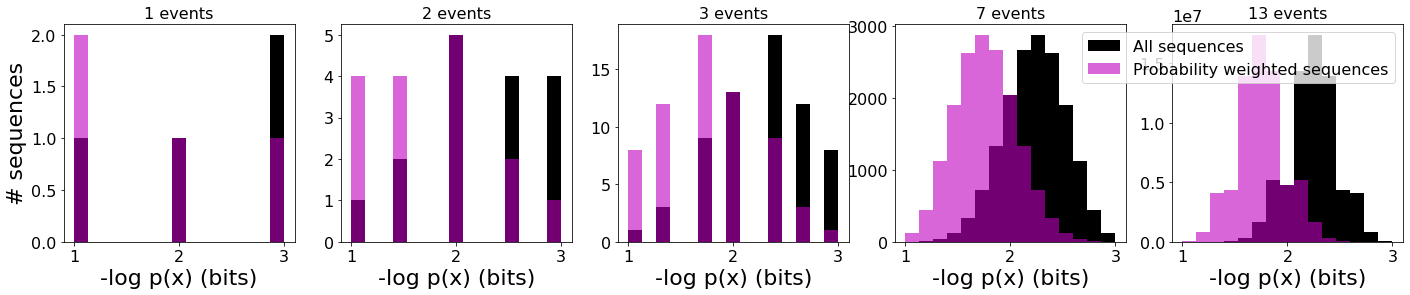

In [11]:
import numpy as np
import matplotlib.pyplot as plt

p_blue = 0.5
p_gray = 0.25
p_yellow = 0.125
p_green = 0.125
probs = np.array([p_blue, p_gray, p_yellow, p_green])


def random_sequence(N):
    sequence = np.random.rand(N)
    ints = np.zeros(shape=(N,), dtype=np.int)
    ints[sequence < p_blue] = 0
    ints[np.logical_and(sequence >= p_blue, sequence < p_blue + p_gray)] = 1
    ints[np.logical_and(sequence >= p_blue + p_gray, sequence < p_blue + p_gray + p_yellow)] = 2
    ints[sequence >= p_blue + p_gray + p_yellow] = 3
    return ints

def enumerate_sequence(N):
    num_sequences = 4 ** N
    indices = np.arange(num_sequences)
    columns = []
    for position in range(N):
        increment = indices.size / 4 ** (position + 1)
        columns.append(indices // increment % 4)
    sequences = np.stack(columns).T.astype(np.int)
    return sequences


# plt.figure(figsize = (25,25))
# plt.imshow(sequences)

sequences = enumerate_sequence(1)

#compute prob of each sequence
information = -np.log2(np.prod(probs[sequences], axis=1))

Ns = list(range(1, 12, 2))
Ns = [1, 2, 3, 7, 13]

fig, ax = plt.subplots(1, len(Ns), figsize=(24,4), sharex=True)

for i, N in enumerate(Ns):
    print('{}\r'.format(N),end='')
    sequences = enumerate_sequence(N)
    
    #compute prob of each sequence
    sequence_prob = np.prod(probs[sequences], axis=1) 
    information = -np.log2(sequence_prob)
    ax[i].hist(information / N,  15, color='k', alpha=1, density=False)
    ax[i].hist(information / N,  15, color='m', weights=sequence_prob * len(sequences), alpha=0.6, density=False)
#                , weights=sequence)
#     ax[i].set_ylabel('# of sequences')
    ax[i].set_xlabel('-log p(x) (bits)')
    ax[i].set_title('{} events'.format(N))
    if i == 0:
        ax[i].set_ylabel('# sequences')
    

plt.legend(['All sequences', 'Probability weighted sequences'])    
plt.savefig('typicality.pdf', transparent=True)

# Entropy rate
Show the convergence of average and conditional entropy

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

#editable text in fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#make text on figures look good
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

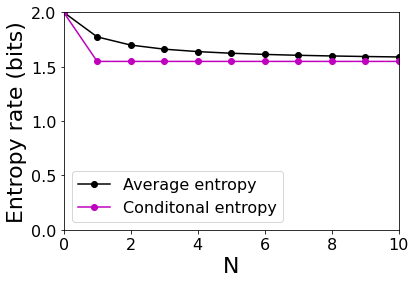

In [5]:
import numpy as np
initial_prob = np.array([1/4, 1/4, 1/4, 1/4])
transition_prob = np.array([[5/8, 1/8, 1/8, 1/8], 
                [1/8, 5/8, 1/8, 1/8],
                [1/8, 1/8, 5/8, 1/8],
                [1/8, 1/8, 1/8, 5/8]])

joint_prob = initial_prob
average_entropy_list = [np.sum(initial_prob * -np.log2(initial_prob))]
cond_entropy_list = [np.sum(initial_prob * -np.log2(initial_prob))]
N = 10
for i in range(N):
    joint_prob = transition_prob * joint_prob[..., None]
    marginal = np.sum(joint_prob, axis=0)[None]
    conditional = joint_prob / marginal
    cond_entropy = np.sum(joint_prob * -np.log2(conditional)) 
    joint_entropy = np.sum(joint_prob * -np.log2(joint_prob))
    average_entropy_list.append(joint_entropy / joint_prob.ndim)
    cond_entropy_list.append(cond_entropy)
    
plt.figure()
plt.plot(average_entropy_list, '-ko')
plt.plot(cond_entropy_list, '-mo')
plt.xlabel('N')
plt.ylabel('Entropy rate (bits)')
plt.ylim([0, 2]) 
plt.xlim([0, N])
plt.legend(['Average entropy', 'Conditonal entropy'])
plt.savefig('Entropy_rate.pdf', transparent=True)

# Enocders/channel capacity
Various ways of computing channel capacity

## Functions used through below sections

In [11]:
import numpy as onp
import jax.numpy as np
from jax import grad, value_and_grad
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import matplotlib as mpl
import matplotlib.pyplot as plt

#editable text in fonts
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#make text on figures look good
SMALL_SIZE = 16
MEDIUM_SIZE = 22
BIGGER_SIZE = 28
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def entropy(p_x):
    x_info = -np.log2(p_x)
    valid_mask = np.logical_not(np.isinf(p_x))
    return np.sum(p_x[valid_mask] * x_info[valid_mask])

def compute_mutual_info(p_x, channel, zero_threshold=1e-34):
    """
    Compute the mutual information for a given channel and input distribution p_x
    """
    p_y = channel @ p_x
    # Mask out any 0 probability y values for gradient purposes
    y_mask = p_y > zero_threshold
    p_y = p_y[y_mask]
    joint = (channel * p_x.reshape((1, p_x.size)))[y_mask]
    cond = channel[y_mask]
    cond_info = -np.log2(cond[cond > zero_threshold])
    h_y_mid_x = np.sum(cond_info * joint[cond > zero_threshold])
    h_y = entropy(p_y)
    mutual_info = h_y - h_y_mid_x
    # print(np.any(np.isnan(cond_info)), np.any(np.isnan(joint[cond != 0])))
    # print(cond[cond != 0][87])
    return mutual_info

def optimize_input_probability(p_x, channel, learning_rate = 1e-2, tolerance =1e-6):
    """
    Optimize input probabilities p_x to maximize mutual information for a given channel
    """
    def loss(p_x):
        mi = compute_mutual_info(p_x, channel)
        return -mi
    
    grad_fn = value_and_grad(loss)    
    prev_val = 0
    for i in range(10000):
        loss, p_x_grad = grad_fn(p_x)
        p_x -= learning_rate * p_x_grad
       
        # Proximal operator: enforce positivity of probability and summation to one
        # p_x = np.where(p_x>=0, p_x, 1e-3)
        p_x = np.where(p_x>=0, p_x, 0)
        p_x += (1 - np.sum(p_x)) / p_x.size
        
        mutual_info = compute_mutual_info(p_x, channel)
        print('{}:\t loss: {:.3f}\tmutual_info: {:.3f}\tprob(x): {}                            \r'.format(
            i, loss, mutual_info, 
            [(p_x.size * '{:.3f} ').format(*p_x)]), end='')        
        if np.abs(loss - prev_val) < tolerance:
            break
        prev_val = 0.9 * prev_val + 0.1 * loss #exponential moving average

    print('\n\nComplete.')
    print('prob(x): ', p_x)
    print('mutual information: ', mutual_info)
    return p_x, mutual_info


## Optimize input distribution to compute capcity and p_x optimal

In [16]:
#intial value
p_x = np.array([1/4, 1/4, 1/4, 1/4, 0, 0])
# p_x = np.array([3/4, 1/12, 1/12, 1/12])

# channel =  np.array([ [1/2, 0, 0, 1/2],
#                       [1/2, 1/2, 0, 0],
#                       [0, 1/2, 1/2, 0],
#                       [0, 0, 1/2, 1/2] ])
# channel =  np.array([ [3/4, 3/16, 1/8, 3/8],
#                       [1/8, 3/8, 1/8, 1/16],
#                       [1/16, 2/8, 1/2, 1/16],
#                       [1/16, 3/16, 1/4, 1/2] ])



# p_x = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
# channel =  np.array([ [1/4,  0,    0,    1/4,  1/4,   1/4],
#                       [1/4,  1/4,  0,    0,    1/4,   1/4],
#                       [1/4,  1/4,  1/4,  0,    0,     1/4],
#                       [1/4,  1/4,  1/4,  1/4,  0,     0],
#                       [0,    1/4,  1/4,  1/4,  1/4,   0],
#                       [0,    0,    1/4,  1/4,  1/4,   1/4],
#                     ])


channel =  np.array([ [1/3, 1/3,  0,    0,   1/3, 1/3],
                      [1/3, 1/3,  1/3,  0,   0, 0],
                      [1/3, 1/3,  1/3,  0,   0, 0],
                      [0,   0,  1/3,  1/3, 0, 0],
                      [0,   0,  0,    1/3, 1/3, 1/3],
                      [0,   0,  0,    1/3, 1/3, 1/3],
                    ])

#Compute optimal input distribution
optimal_p_x, capacity = optimize_input_probability(p_x, channel, learning_rate = 1e-2)
print(optimal_p_x, capacity)

p = 0.18
p_x = np.array([1/4 - p, 1/4 + p, 1/4 - p, 1/4 + p, 0, 0])
print('assymetric distribution', compute_mutual_info(p_x, channel))

139:	 loss: -1.000	mutual_info: 1.000	prob(x): ['0.167 0.167 0.167 0.333 0.083 0.083 ']                            

Complete.
prob(x):  [0.16668603 0.16668603 0.16668591 0.33331415 0.08331395 0.08331395]
mutual information:  1.0
[0.16668603 0.16668603 0.16668591 0.33331415 0.08331395 0.08331395] 1.0
assymetric distribution 0.9905431


## Find all encoders that are permutations of the distritubtion -- i.e. match each state to every one input


not equiprobable 1.0000001 [0.   0.43 0.07 0.   0.43 0.07]
Equiprobable 0.91829586 [0.         0.33333334 0.         0.33333334 0.         0.33333334]


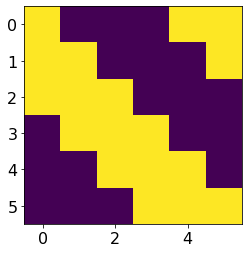

In [431]:
from itertools import permutations

p = 0.18

p_x = np.array([1/4 - p, 1/4 + p, 1/4 - p, 1/4 + p, 0, 0])


# channel =  np.array([ [1/3, 1/3,  0,    0,   1/3, 1/3],
#                       [1/3, 1/3,  1/3,  0,   0, 0],
#                       [1/3, 1/3,  1/3,  0,   0, 0],
#                       [0,   0,  1/3,  1/3, 0, 0],
#                       [0,   0,  0,    1/3, 1/3, 1/3],
#                       [0,   0,  0,    1/3, 1/3, 1/3],
                    # ])

# channel =  np.array([ [1/4,  0,    0,    1/4,  1/4,   1/4],
#                       [1/4,  1/4,  0,    0,    1/4,   1/4],
#                       [1/4,  1/4,  1/4,  0,    0,     1/4],
#                       [1/4,  1/4,  1/4,  1/4,  0,     0],
#                       [0,    1/4,  1/4,  1/4,  1/4,   0],
#                       [0,    0,    1/4,  1/4,  1/4,   1/4],
#                     ])


# channel =  np.array([ [1/2,  0,    0,    0,    0,    1/2],
#                       [1/2,  1/2,  0,    0,    0,    0],
#                       [0,    1/2,  1/2,  0,    0,    0],
#                       [0,    0,    1/2,  1/2,  0,    0],
#                       [0,    0,    0,    1/2,  1/2,  0],
#                       [0,    0,    0,    0,    1/2,  1/2],
#                     ])

channel =  np.array([ [1/3,  0,    0,    0,    1/3,  1/3],
                      [1/3,  1/3,  0,    0,    0,    1/3],
                      [1/3,  1/3,  1/3,  0,    0,    0],
                      [0,    1/3,  1/3,  1/3,  0,    0],
                      [0,    0,    1/3,  1/3,  1/3,  0],
                      [0,    0,    0,    1/3,  1/3,  1/3],
                    ])


p_x_permutations = np.array(list(set(permutations([float(x) for x in p_x]))))
mis = np.array([compute_mutual_info(p, channel) for p in p_x_permutations])
print('not equiprobable', np.max(mis), p_x_permutations[np.argmax(mis)])


p_x = np.array([1/3, 1/3, 1/3, 0, 0, 0])
p_x_permutations = np.array(list(set(permutations([float(x) for x in p_x]))))
mis = np.array([compute_mutual_info(p, channel) for p in p_x_permutations])
print('Equiprobable', np.max(mis), p_x_permutations[np.argmax(mis)])


plt.imshow((channel))

## Grid search optimization to verify gradient optimization is working

In [203]:
# Grid search for verification purposes

p_grid = np.meshgrid(np.linspace(0, 1, 40), np.linspace(0, 1, 40), 
                     np.linspace(0, 1, 40), np.linspace(0, 1, 40))
#make sure valid probabilities
valid_mask = np.abs(np.sum(np.array(p_grid), axis=0) - 1) < 0.01
probs = np.array([g[valid_mask] for g in p_grid]).T
mis = []
for i,p in enumerate(probs):
    print('{}\r'.format(i), end='')
    mis.append(compute_mutual_info(p, channel))
index = np.argmax(np.array(mis))
best_prob_vec = probs[index]
mi = mis[index]
print(best_prob_vec, mi)

# Plot extended channels and distribution of conditional entropies

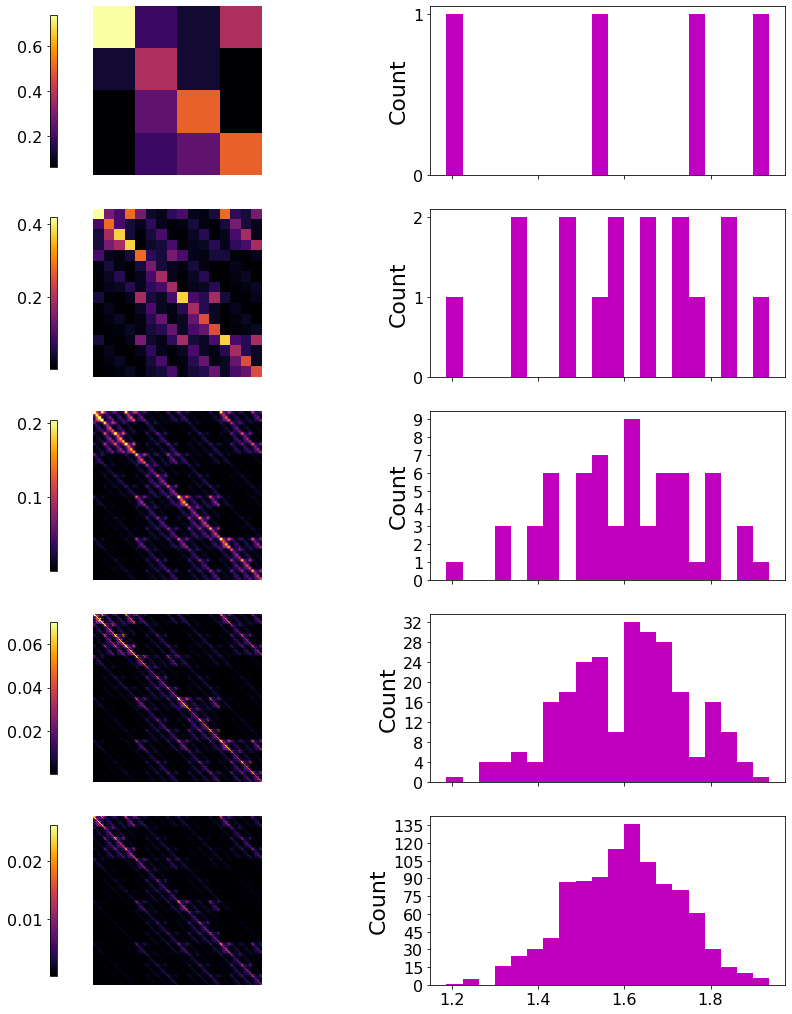

In [2]:
channel =  np.array([ [3/4, 3/16, 1/8, 3/8],
                      [1/8, 3/8, 1/8, 1/16],
                      [1/16, 2/8, 1/2, 1/16],
                      [1/16, 3/16, 1/4, 1/2] ])

# channel =  np.array([ [1/2, 1/2, 0],
#                       [0, 1/2, 1/2],
#                       [1/2, 0, 1/2] ])

def increase_block_length(start, channel):
    extended = np.array([[start * channel[i,j] for j in
                          np.arange(channel.shape[0])] for i in np.arange(channel.shape[1])])    
    return np.concatenate(np.concatenate(extended, axis=1), axis=1)


max_N = 6
fig, ax = plt.subplots(max_N - 1, 2, figsize=(14, 18))
for N in range(1, max_N):
    if N == 1:
        extended_channel = channel
    else:
        extended_channel = increase_block_length(extended_channel, channel)
    im = ax[N -1, 0].imshow((extended_channel) , cmap='inferno', 
                            vmin=np.percentile(extended_channel, .3),
                           vmax=np.percentile(extended_channel, 99.7)
                           )
    ax[N -1, 0].set_axis_off()
    plt.colorbar(im, ax=ax[N-1, 0], shrink=0.9, location='left')
    cond_entropy = [entropy(extended_channel[:, i]) / N for i in range(extended_channel.shape[1])]
    ax[N - 1, 1].hist(onp.stack(cond_entropy), 20, color='m')
    ax[N -1, 1].set_ylabel('Count')
    ax[N -1, 1].yaxis.set_major_locator(MaxNLocator(integer=True))
    if N != max_N -1:
        ax[N -1, 1].set_xticklabels([])

plt.savefig('extended_channel.pdf', transparent=True, dpi=300)

# Compute optimal distribution used in one of the figures

In [7]:
channel =  np.array([ [1/4,   0,  0],
                      [1/4,   0,  0],
                      [1/4,   0,  0],
                      [1/4,   1/2,    0],
                      [0,     1/2,    1/4],
                      [0,     0,    1/4],
                      [0,     0,    1/4],
                      [0,     0,    1/4],
                    ])

p_x = np.array([1/3, 1/3, 1/3])
#Compute optimal input distribution
optimal_p_x, capacity = optimize_input_probability(p_x, channel, learning_rate = 1e-2)
print(optimal_p_x, capacity)

print('output distribution', channel @ optimal_p_x)

191:	 loss: -1.131	mutual_info: 1.131	prob(x): ['0.362 0.276 0.362 ']                            

Complete.
prob(x):  [0.36190584 0.27618834 0.36190584]
mutual information:  1.1312928
[0.36190584 0.27618834 0.36190584] 1.1312928


# Another mutual information computation for one of the figures

In [10]:
p_x = np.array([1/3, 1/3, 1/3])
channel =  np.array([ [1/2,   0,    0],
                      [1/2,   1/2,  0],
                      [0,     1/2,  1/2],
                      [0,     0,    1/2],    
                      [0,     0,    0],
                      [0,     0,    0],
                    ])
print(compute_mutual_info(p_x, channel))


p_x = np.array([1/3, 1/3, 1/3])
channel =  np.array([ [1/2,   0,    0],
                      [1/2,   0,  0],
                      [0,     1/2,  0],
                      [0,     1/2,  0],    
                      [0,     0,    1/2],
                      [0,     0,    1/2],
                    ])
print(compute_mutual_info(p_x, channel))

0.91829586
1.5849626
